In [2]:
# import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'Quadro RTX 8000'

In [5]:
torch.cuda.empty_cache()

In [6]:
train_df = pd.read_csv('./data/ratings_train.txt', sep='\t')
test_df = pd.read_csv('./data/ratings_test.txt', sep='\t')

In [7]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df = train_df.sample(frac=0.8, random_state=999)
test_df = test_df.sample(frac=0.8, random_state=999)

In [8]:
sentences = train_df['document']

In [9]:
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

In [10]:
labels = train_df['label'].values

In [122]:
len(labels)

119996

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [12]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [13]:
print(sentences[0])
print(tokenized_texts[0])

[CLS] 이 영화(제작과정포함)를 접한 후 결론 → 샤론스톤은 쓰레기다. [SEP]
['[CLS]', '이', '영화', '(', '제작', '##과', '##정', '##포', '##함', ')', '를', '접', '##한', '후', '결', '##론', '→', '샤', '##론', '##스', '##톤', '##은', '쓰', '##레', '##기', '##다', '.', '[SEP]']


In [14]:
import tensorflow as tf
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

In [15]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9638,  42428,    113, 104865,  11882,  16605,  55530,
        48533,    114,   9233,   9669,  11102,  10003,   8881,  42769,
         1791,   9421,  42769,  12605, 119358,  10892,   9511,  56645,
        12310,  11903,    119,    102,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [16]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [17]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [18]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
device = torch.device("cuda")

In [66]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [21]:
from tqdm import tqdm

In [67]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 1

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [109]:
y_pred = np.array([])
y_true = np.array([])

In [96]:
# # 정확도 계산 함수
# def flat_accuracy(preds, labels):
#     global y_pred
#     global y_true
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     y_pred += pred_flat
#     y_true += labels_flat
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [70]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [127]:
ids , m , la =  next(iter(train_dataloader))

In [160]:
ids.shape

torch.Size([32, 128])

In [161]:
m.shape

torch.Size([32, 128])

In [162]:
la.shape

torch.Size([32])

In [71]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm(train_dataloader)):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, attention_mask=b_input_mask,labels=b_labels)
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

  0%|          | 0/3375 [00:00<?, ?it/s]


======== Epoch 1 / 1 ========
Training...


 15%|█▍        | 500/3375 [02:12<12:41,  3.78it/s]

  Batch   500  of  3,375.    Elapsed: 0:02:12.


 30%|██▉       | 1000/3375 [04:24<10:28,  3.78it/s]

  Batch 1,000  of  3,375.    Elapsed: 0:04:25.


 44%|████▍     | 1500/3375 [06:37<08:16,  3.77it/s]

  Batch 1,500  of  3,375.    Elapsed: 0:06:37.


 59%|█████▉    | 2000/3375 [08:49<06:02,  3.79it/s]

  Batch 2,000  of  3,375.    Elapsed: 0:08:49.


 74%|███████▍  | 2500/3375 [11:01<03:50,  3.80it/s]

  Batch 2,500  of  3,375.    Elapsed: 0:11:01.


 89%|████████▉ | 3000/3375 [13:13<01:38,  3.79it/s]

  Batch 3,000  of  3,375.    Elapsed: 0:13:13.


100%|██████████| 3375/3375 [14:51<00:00,  3.78it/s]


  Average training loss: 0.39
  Training epcoh took: 0:14:52

Running Validation...


UnboundLocalError: local variable 'y_pred' referenced before assignment

In [110]:
# ========================================
#               Validation
# ========================================

print("")
print("Running Validation...")

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for batch in validation_dataloader:
    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 출력 로짓과 라벨을 비교하여 정확도 계산
#     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat =  label_ids.flatten()
    y_pred = np.concatenate((y_pred,pred_flat),axis=None)
    y_true = np.concatenate((y_true,labels_flat),axis=None)
    tmp_eval_accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:30


In [111]:
len(y_pred)

12000

In [112]:
len(y_true)

12000

In [105]:
print("")
print("Training complete!")


Training complete!


In [106]:
from sklearn.metrics import classification_report

In [114]:
target_names = ['Pos', 'Neg']

In [115]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Pos       0.86      0.84      0.85      5961
         Neg       0.85      0.87      0.86      6039

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



In [116]:
from torchvision import models

In [119]:
from torchsummary import summary

In [146]:
from sklearn import metrics

In [133]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)

In [144]:
import matplotlib.pyplot as plt

In [147]:
roc_auc = metrics.auc(fpr, tpr)

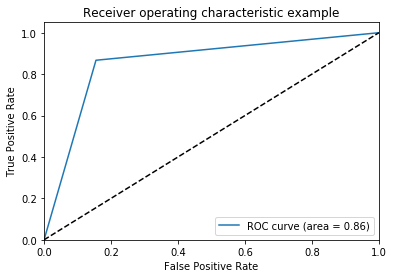

In [148]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [165]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen